In [1]:
import sys
sys.path

['/home/doojung/DSJ/Projects/SciPy2019/dl-workshop-master/notebooks',
 '/home/doojung/anaconda3/envs/dl-workshop/lib/python37.zip',
 '/home/doojung/anaconda3/envs/dl-workshop/lib/python3.7',
 '/home/doojung/anaconda3/envs/dl-workshop/lib/python3.7/lib-dynload',
 '',
 '/home/doojung/anaconda3/envs/dl-workshop/lib/python3.7/site-packages',
 '/home/doojung/anaconda3/envs/dl-workshop/lib/python3.7/site-packages/IPython/extensions',
 '/home/doojung/.ipython']

In [2]:
import jax.numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Linear Regression

Linear regression is foundational to deep learning. It should be a model that everybody has been exposed to before. However, it is important for us to go through this with a view to how we connect linear regression to the neural diagrams that are shown.

## Discussion

- In our machine learning toolkit, where do we use linear regression? everywhere
- What are its advantages? simple, easy to interpret 
- What are its disadvantages? lots of assumptions, 

##### Why cannot we just use a linear model?

[Check this out](https://pydata.org/london2018/schedule/presentation/44/)! You do not always need a deep learning where you can do it with a linear model ;) - Winning with Simple, even Linear, Models, Vincent D. Warmerdam, PyData 2018  

Simple models work. Linear models work. No need for deep learning or complex ensembles, you can often keep it simple. In this talk I'll discuss and demonstrate some winning tricks that you can apply on simple, even linear models.  

It's not like deep learning isn't amazing, it is, but the hype is distracting people from great ideas. You may be doing yourself short if you pay too much attention to them. You can often win with simpler models that have properties that are much nicer in situations beyond a jupyter notebook (production).  

I'll be discussing approaches that are dated, but useful. My goal is to lure you back to the domain of boring, old but ultimately simpler models that can win the day. I'll share some war-stories from my last 4 years of consulting work as well as some hard learned lessons.  

The following topics will be discussed:  

* how to solve the xor problem with linear models
* how to win at timeseries with radial basis features
* how to use weighted regression to deal with historical overfitting
* how deep learning models introduce a new theme of horror in production
* how to play with domain specific languages for ML models
* how to apply domain knowledge for graphical models
* how to create streaming models using passive aggressive updating
* how to build a real-time video game ranking system using mere histograms
* how to create a well performing recommender with two SQL tables


## Equation Form

Linear regression, as a model, is expressed as follows:

$$y = wx + b$$

Here:

- The **model** is the equation, $y = wx + b$.
- $y$ is the output data.
- $x$ is our input data.
- $w$ is a slope parameter.
- $b$ is our intercept parameter.
- Implicit in the model is the fact that we have transformed $y$ by another function, the "identity" function, $f(x) = x$.

In this model, $y$ and $x$ are, in a sense, "fixed", because this is the data that we have obtained. On the other hand, $w$ and $b$ are the parameters of interest, and *we are interested in **learning** the parameter values for $w$ and $b$ that let our model best explain the data*.

I will reveal the punchline early:

> The **learning** in deep learning is about figuring out parameter values for a given model.

## Make Simulated Data

To explore this idea in a bit more depth as applied to a linear regression model, let us start by making some simulated data with a bit of injected noise.

You can specify a true $w$ and a true $b$ as you wish, or you can just follow along.

### Exercise

/home/doojung/anaconda3/envs/dl-workshop/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Text(0, 0.5, 'y')

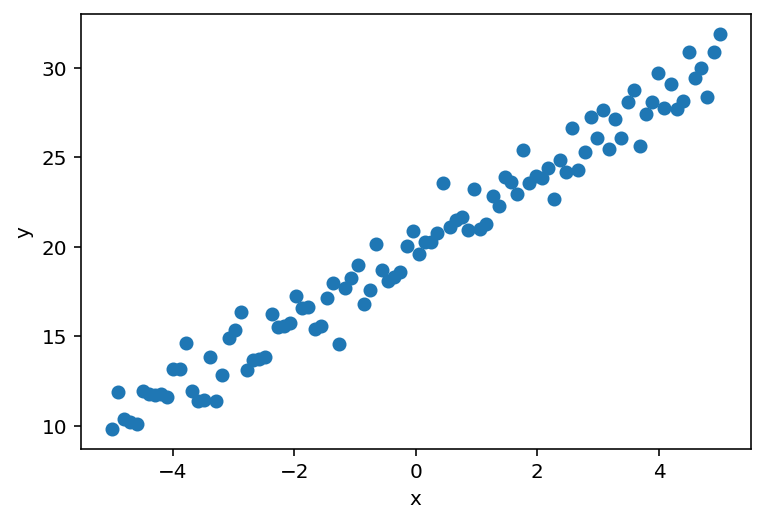

In [3]:
x = np.linspace(-5, 5, 100)
w_true = 2  # exercise: specify ground truth w.
b_true = 20  # exercise: specify ground truth b.

def noise(n):
    return npr.normal(size=(n))

# exercise: write the linear equation down.
y = w_true * x + b_true + noise(len(x))

# Plot ground truth data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

### Exercise

Now, let's plot what would be a very bad estimate of $w$ and $b$. 

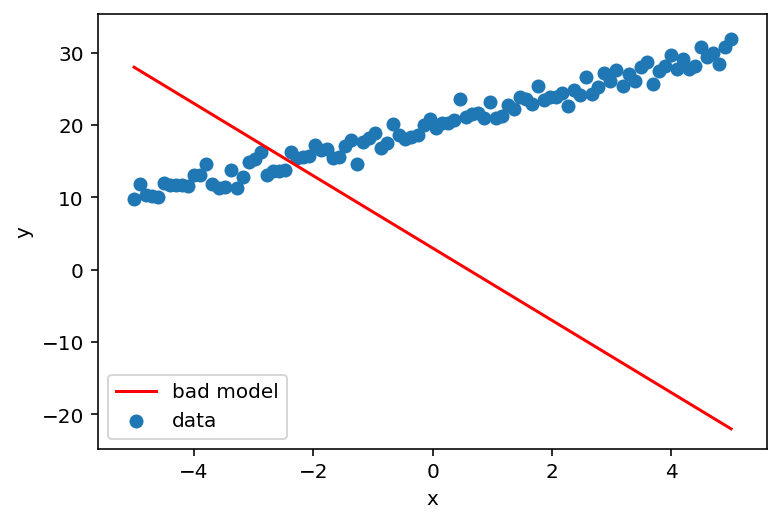

In [4]:
# Plot a very bad estimate
w = -5  # exercise: fill in a bad value for w
b = 3   # exercise: fill in a bad value for b
y_est = w * x + b  # exercise: fill in the equation.
plt.plot(x, y_est, color='red', label='bad model')
plt.scatter(x, y, label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## Loss Function

How bad is our model? We can quantify this by looking at a metric called the "mean squared error". The mean squared error is defined as "the average of the sum of squared errors".

"Mean squared error" is but one of many **loss functions** that are available in deep learning frameworks. It is commonly used for regression tasks.

Loss functions are designed to quantify how bad our model is in predicting the data.



![loss_func_for_linear_reg_mae](../img/loss_func_for_linear_reg_mae.png)

![loss_func_for_linear_reg_mse](../img/loss_func_for_linear_reg_mse.png)

### Exercise

Let's implement the mean squared error function.

In [5]:
# Exercise: implement mean squared error function in NumPy code.
# It should take in y_true and y_pred as arguments,
# and return a scalar.
def mse(y_true, y_pred):
    # Your code here
    error = y_true - y_pred  # residuals 
    sq_err = np.power(error, 2)
    return np.mean(sq_err)

# Calculate the mean squared error between 
mse(y, y_est)

DeviceArray(711.99005, dtype=float32)

### Activity: Optimize model by hand.

Now, we're going to optimize this model by hand. Use the sliders provided to adjust the model.

In [6]:
@interact(
    w=FloatSlider(min=-10, max=10, step=0.1), 
    b=FloatSlider(min=0, max=30, step=0.1)
)
def optimize_plot(w, b):
    y_est = x * w + b
    plt.scatter(x, y, alpha=0.3, label='data')
    plt.plot(x, y_est, color='red', label='model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'MSE: {mse(y, y_est):.02f}')

interactive(children=(FloatSlider(value=0.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

### Discussion

As you were optimizing the model, what did you notice about the MSE? score? A: Decreasing!  

Anything related to 'minima' => think about derivatives

# Detour: Gradient-Based Optimization

Implicit in what you were doing was something we formally call "gradient-based optimization". This is a very important point to understand. If you get this for a linear model, you will understand how this works for more complex models. Hence, we are going to go into a small crash-course detour on what gradient-based optimization is.

## Derivatives

At the risk of ticking off mathematicians for a sloppy definition, for this workshop's purposes, a useful way of defining the derivative is:

> How much our output changes as we take a small step on the inputs, taken in the limit of going to very small steps.

If we have a function:

$$f(w) = w^2 + 3w - 5$$

What is the derivative of $f(x)$ with respect to $w$? From first-year undergraduate calculus, we should be able to calculate this:

$$f'(w) = 2w + 3$$

(We will use the apostrophe marks to indicate derivatives. 1 apostrophe mark means first derivative, 2nd apostrophe mark means 2nd derivative.)

## Minimizing $f(w)$ Analytically

What is the value of $w$ that minimizes $f(w)$? Again, from undergraduate calculus, we know that at a minima of a function (whether it is a global or local), the first derivative will be equal to zero, i.e. $f'(w) = 0$. By taking advantage of this property, we can analytically solve for the value of $w$ at the minima.

$$2w + 3 = 0$$

Hence, 

$$w = -\frac{3}{2} = 1.5$$

To check whether the value of $w$ at the place where $f'(w) = 0$ is a minima or maxima, we can use another piece of knowledge from 1st year undergraduate calculus: The sign of the second derivative will tell us whether this is a minima or maxima.

- If the second derivative is positive regardless of the value of $w$, then the point is a minima. (Smiley faces are positive!)
- If the second derivative is negative regardless of the value of $w$, then the point is a maxima. (Frowning faces are negative!)

Hence, 

$$f''(w) = 2$$

We can see that $f''(w) > 0$ for all $w$, hence the stationary point we find is going to be a local minima.

## Minimizing $f(w)$ Computationally

An alternative way of looking at this is to take advantage of $f'(w)$, the gradient, evaluated at a particular $w$. A known property of the gradient is that if you take steps in the negative direction of the gradient, you will eventually reach a function's minima. If you take small steps in the positive direction of the gradient, you will reach a function's maxima (if it exists).

### Exercise

Let's implement this using the function $f(w)$, done using NumPy.

In [7]:
# Exercise: Write f(w) as a function.
def f(w):
    """
    Note: We don't use this function in this
    cell.
    """
    return w**2 + 3 * 2 - 5


# Exercise: Write df(w) as a function. 
def df(w):
    """
    Derivative of f with respect to w.
    """
    return 2 * w + 3

# Exercise: Pick a number to start w at.
w = 2.11  # start with a float

# Now, adjust the value of w 1000 times, taking small steps in the negative direction of the gradient.
# A learning rate, alpha
alpha = 0.01
for i in range(1000):
    w = w - df(w) * alpha
    
print(w) # should be close to -1.5

-1.499999993924488


In [8]:
# A large learning rate, alpha_large 
w = 2.11  # start with a float
alpha_large = 10
for i in range(1000):
    w = w - df(w) * alpha_large
    
print(w) 

nan


In [9]:
# Only run for a few times, two or three times
w = 2.11  # start with a float
alpha = 0.01
for i in range(2):
    w = w - df(w) * alpha
    
print(w) 

1.9670439999999998


Congratulations, you have just implemented **stochastic gradient descent** (SGD)!

Stochastic gradient descent is an **optimization routine**: a way of programming a computer to do optimization for you so that you don't have to do it by hand.

## Minimizing $f(w)$ with `jax`

`jax` is a Python package for automatically computing gradients; it is known as an ["automatic differentiation"](https://en.wikipedia.org/wiki/Automatic_differentiation) system. This way, we do not have to specify the gradient function by hand-calculating it; rather, `jax` will know how to automatically take the derivative of a Python function w.r.t. the first argument. With `jax`, our example above is modified in only a slightly different way.

* [Google JAX](https://github.com/google/jax)  
* [Colin Carroll's post: Exercises in Automatic Differentiation using Autograd and JAX](https://colindcarroll.com/2019/04/06/exercises-in-automatic-differentiation-using-autograd-and-jax/)  
* [Colin Raffel's poist: You don't know JAX](https://colinraffel.com/blog/you-don-t-know-jax.html)

In [10]:
from jax import grad
from tqdm import tqdm_notebook as tqdmn

def f(w):
    return w**2 + 3 * w - 5

# This is what changes: we use autograd's `grad` function to automatically return a gradient function.
df = grad(f)
print(f"type(df): {type(df)}")
print(f"df      : {df}")

# Exercise: Pick a number to start w at.
w = -10.0 # must be a float

# Now, adjust the value of w 1000 times, taking small steps in the negative direction of the gradient.
alpha = 0.01
for i in tqdmn(range(1000)):
    w = w - df(w) * alpha
    
print(w)

type(df): <class 'function'>
df      : <function grad.<locals>.grad_f at 0x7ff12b4f8710>



-1.5000029


# Back to Optimizing Linear Regression

## What are we optimizing?

In linear regression, we are minimizing (i.e. optimizing) the loss function w.r.t. the linear regression parameters.

**Keep in mind:** The loss function is the parallel to the $f(w)$ polynomial function that we were playing around with above.

## Ingredients for "Optimizing" a Model

At this point, we have learned what the ingredients are for optimizing a model:

1. A model, which is a function that maps inputs $x$ to outputs $y$, and its parameters of the model. In our linear regression case, this is $w$ and $b$; usually, in the literature, we call this a **parameter set** $\theta$.
2. Loss function, which tells us how bad our predictions are.
3. Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.

**Keep note:** Because we are optimizing the loss w.r.t. two parameters, finding the $w$ and $b$ coordinates that minimize the loss is like finding the minima of a bowl.

The latter point, which is "how to adjust the parameter values to minimize the loss function", is the key point to understand here. 

## Code-Along Exercise

We are going to write code to tie this all together. In order help you follow along, I will type this in full, but you will only have to fill-in-the-blanks. 

In [11]:
# Exercise: Define the model
def model(p, x):
    """
    A simple linear regression.
    :param p: parameters, a dictionary. Should have 
        keys: 'w' and 'b', which map to floating 
        point numbers. In JAX and Autograd, parameters 
        must be the first arg.    
    :param x: x-values for the function.
    """
    return p['w'] * x + p['b']

# Initialize values of w and b. 
# We will store the parameter values in a dictionary.
# The dict keys are the name of the parameter,
# and the dict values are the parameter values.
# JAX does not like using numpy's random generator but
# here we use it for the time being...
params = dict()
params['w'] = npr.normal()  # draw one value from standard normal
params['b'] = npr.normal()  # FITB


# Differentiable loss function w.r.t. 1st argument
def mseloss(params, model, x, y):
    """
    :param params: parameters to optimize
    :param model: A function to unflatten the parameters 
        into its original data structure.
    :param x: input data
    :param y: correct outputs
    """
    y_est = model(params, x)      # FITB
    return mse(y, y_est)          # FITB

dmseloss = grad(mseloss)  # derivative of loss function

# Optimization routine
losses = []
for i in tqdmn(range(3000)):
    # Evaluate the gradient at the given params values.
    grad_p = dmseloss(params, model, x, y)
    
    # Update the gradient values for each parameter.
    alpha = 0.001
    for k, p in params.items():
        params[k] = params[k] - grad_p[k] * alpha
        
    # Keep track of losses.
    losses.append(mseloss(params, model, x, y))

In [12]:
# a dict: value = current value
params

{'w': DeviceArray(2.0315716, dtype=float32),
 'b': DeviceArray(19.995798, dtype=float32)}

In [13]:
# a dict with the same keys: value = grad value
grad_p

{'b': DeviceArray(-0.09800773, dtype=float32),
 'w': DeviceArray(-0.00011653, dtype=float32)}

Now, let's plot the loss score over time. It should be going downwards.

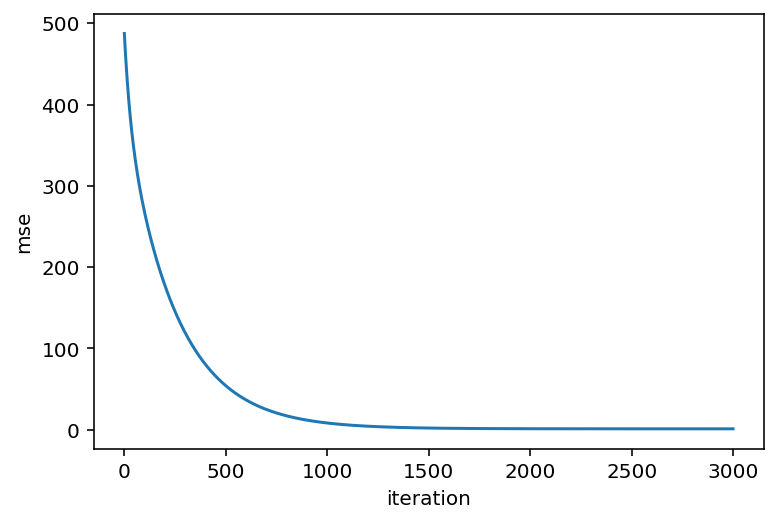

In [14]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

In [15]:
from pprint import pprint

pprint(params)

{'b': DeviceArray(19.995798, dtype=float32),
 'w': DeviceArray(2.0315716, dtype=float32)}


# Recap: Ingredients

1. Model specification ("equations", e.g. $y = wx + b$) and the parameters of the model to be optimized ($w$ and $b$, or more generally, $\theta$).
2. Loss function: tells us how wrong our model parameters are w.r.t. the data ($MSE$) => it needs to be differenciable.
3. Opitmization routine (for-loop) => number of iterations, step size (i.e. learning rate)

![mse_algebra_part1](../img/mse_algebra_part1.png)

![mse_algebra_part2](../img/mse_algebra_part2.png)

# Linear Regression, Extended

Thus far, we have shown linear regression using only one-dimensional inputs (i.e. one column of data). Linear regression has been extended to higher dimensional inputs, i.e. two or more columns of data.

## In Pictures

Linear regression can be expressed pictorially, not just in equation form. Here are two ways of visualizing linear regression.

### Matrix Form

Linear regression in one dimension looks like this:  
(column vector X, y)

![](../figures/linreg-scalar.png)

Linear regression in higher dimensions looks like this:  
(X: k, 4)  
(w: 4, 1)  
(b: k, 1)  
(y: k, 1)  

![](../figures/linreg-matrices.png)

### Neural Diagram

We can draw a "neural diagram" based on the matrix view, with the implicit "identity" function included. (f(x) = x, identity activation function)
* no hidden layer
* identity activation function

![](../figures/linreg-neural.png) 

The neural diagram is one that we commonly see in the introductions to deep learning. As you can see here, linear regression, when visualized this way, can be conceptually thought of as the baseline model for understanding deep learning. 

The neural diagram also expresses the "compute graph" that transforms input variables to output variables.

# Break (10 min.)

# Extension beyond Linear Regression

A key idea from this tutorial is to treat the aforementioned four ingredients as being **modular** components of machine learning. This means that we can swap out the model (and its associated parameters) to fit the problem that we have at hand.

# Logistic Regression

Logistic regression builds upon linear regression. We use logistic regression to perform **binary classification**, that is, distinguishing between two classes. Typically, we label one of the classes with the integer 0, and the other class with the integer 1.

![logistic regression1](../img/logistic_reg1.png)

![logistic regression2](../img/logistic_reg2.png)

L(x) can be written with z, so L(z)  
z = w * x + b

![logistic regression3](../img/logistic_reg3.png)

## Model in Pictures

To help you build intuition, let's visualize logistic regression using pictures again.

### Matrix Form

![](../figures/logreg-matrices.png)

### Neural Diagram

![](../figures/logreg-neural.png)

## Interactive Activity

As should be evident from the pictures, logistic regression builds upon linear regression simply by **changing the activation function from an "identity" function to a "logistic" function**. In the one-dimensional case, it has the same two parameters as one-dimensional linear regression, $w$ and $b$. Let's use an interactive visualization to visualize how the parameters $w$ and $b$ affect the shape of the curve.

In [16]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


@interact(
    w=FloatSlider(min=-5, max=5, step=0.1, value=1), 
    b=FloatSlider(min=-5, max=5, step=0.1, value=1)
)
def plot_logistic(w, b):
    x = np.linspace(-10, 10, 1000)
    z = w * x + b  # linear transform on x
    y = logistic(z)
    plt.plot(x, y)

interactive(children=(FloatSlider(value=1.0, description='w', max=5.0, min=-5.0), FloatSlider(value=1.0, descr…

## Discussion

1. What do $w$ and $b$ control, respectively?   
  * as w increases, getting sharper transistion from 0 to 1. At w=0, flat line.   
  * as b increases, the middle point moves toward negative. At b=0, the middle point is zero.   
2. Where else do you see logistic-shaped curves?

## Make simulated data

In this section, we're going to show that we can optimize a logistic regression model using the same set of ingredients. 

First off, let's start by simulating some data.

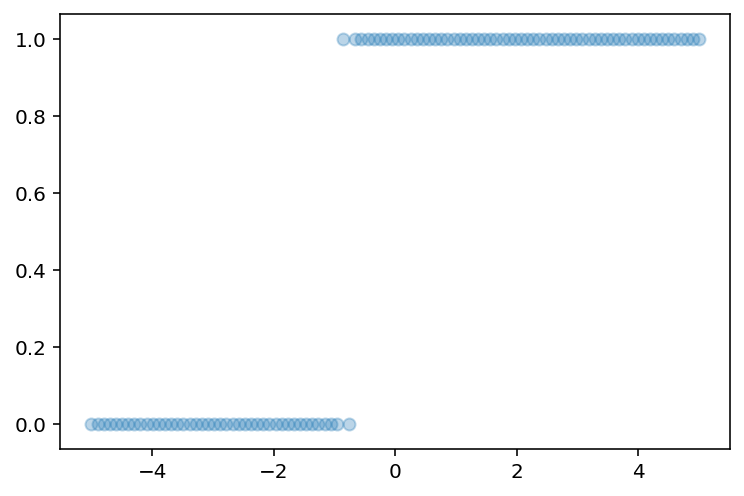

In [17]:
x = np.linspace(-5, 5, 100)
w = 2
b = 1
z = w * x + b + npr.random(size=len(x))
y_true = np.round(logistic(z))
plt.scatter(x, y_true, alpha=0.3)

## Loss Function

How would we quantify how good or bad our model is? In this case, we use the logistic loss function, also known as the *binary cross entropy loss function*.

Expressed in equation form, it looks like this:

$$L = -(y \log(p) + (1-y)\log(1-p))$$

Here:

- $y$ is the actual class, namely $1$ or $0$.
- $p$ is the predicted class. It can be interpreted as the probability of being class 1.

If you're staring at this equation, and thinking that it looks a lot like the Bernoulli distribution log likelihood, you are right!

### Discussion

Let's think about the loss function for a moment:

- What happens to the term $y \log(p)$ when $y=0$ and $y=1$? What about the $(1-y)\log(1-p)$ term?
- What happens to both terms when $p \approx 0$ and when $p \approx 1$ (but still bounded between 0 and 1)?

### Exercise

Now, let's write down the logistic model.

In [18]:
# Exercise: Define logistic model
def logistic_model(p, x):
    """
    Logistic regression model.
    """
    # z = w * x + b
    z = p['w'] * x + p['b']
    
    # L(z)
    y = logistic(z)
    return y

# Exercise: Define logistic loss function, using flattened parameters
def logistic_loss(p, model, x, y):
    """
    :param model: a logistic model
    """
    # y_hat
    preds = model(p, x)
    
    # np.mean or np.sum are both valid but we need one of them
    # to make the output value scalar
    return -np.mean(y * np.log(preds) + (1 - y) * np.log(1 - preds))

# Exercise: Define gradient of loss function.
dlogistic_loss = grad(logistic_loss)

# Exercise: Define parameters, and then flatten them.
params = dict()
params['w'] = npr.random() # or npr.normal() is fine
params['b'] = npr.random() # or npr.normal() is fine

# Exercise: write SGD training loop.
losses = []
for i in tqdmn(range(5000)): 
    
    # Evaluate gradient
    grad_p = dlogistic_loss(params, logistic_model, x, y_true)
    
    # Update parameters
    for name, value in grad_p.items():
        params[name] = params[name] - value * 0.001
    
    # Keep track of losses - an useful diagnostic plot    
    losses.append(logistic_loss(params, logistic_model, x, y_true))

In [19]:
pprint(params)

{'b': DeviceArray(0.6022089, dtype=float32),
 'w': DeviceArray(1.2541144, dtype=float32)}


You'll notice that the values are off from the true value. Why is this so? Partly it's because of the noise that we added, and we also rounded off values.

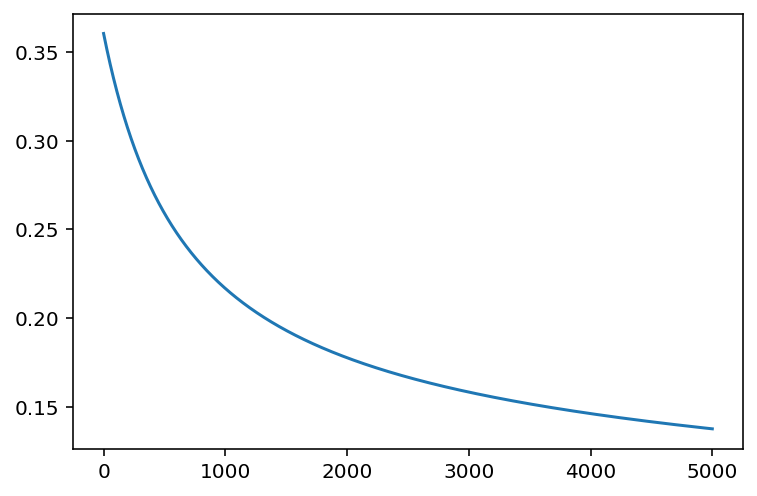

In [20]:
plt.plot(losses)

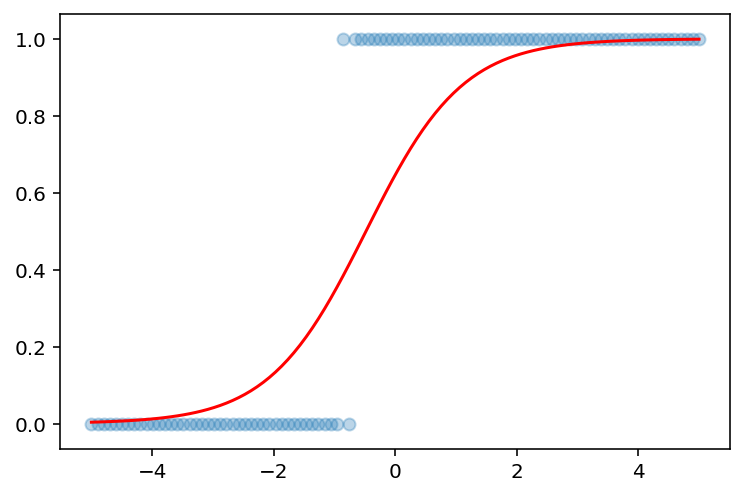

In [21]:
plt.scatter(x, y_true, alpha=0.3)
plt.plot(x, logistic_model(params, x), color='red')

### Exercise

What if we did not round off the values, and did not add noise to the original data? Try re-running the model without those two.

# Neural Networks

Neural networks are basically very powerful versions of logistic regressions. Like linear and logistic regression, they also take our data and map it to some output, but does so without ever knowing what the true equation form is.

That's all a neural network model is: an arbitrarily powerful model.

## Feed Forward Neural Networks in Pictures

To give you an intuition for this, let's see one example of a deep neural network in pictures.

### Matrix diagram

As usual, in a matrix diagram.

![](../figures/deepnet_regressor-matrices.png)

### Neural diagram

And for correspondence, let's visualize this in a neural diagram.

![](../figures/deepnet_regressor-neural.png)

Two activations:  
* The first activation: right after tanh  
* The second activation: right after relu  

'Dense' layers:  
* W1 and W2
* because we're doing the full matrix multiplication  

Relu is not differentible at zero:  
[Quora](https://www.quora.com/Why-does-ReLU-work-with-backprops-if-its-non-differentiable)

> ReLU is differentiable, but not at 0, so we just set the discontinuity at x=0 to have a derivative of zero. (You can choose between 1 and 0, standard practice is zero)  

> we can use something called the sub-gradient. Essentially the main idea is that we can draw lots of tangent lines under to that point, since they are all “correct tangents”, thus just choose one for gradient descent.  

[Another Quora](https://www.quora.com/How-do-we-compute-the-gradient-of-a-ReLU-for-backpropagation)

> Tl;dr: Its not defined but that doesn’t matter in the context of gradient descent. If you really care, then read on.  
Since the ReLu is just: ReLU(x)=max{0,x}, the gradient = 0 for x < 0 and 1 for x > 0.   
For x = 0, what you define the gradient as does not matter.  
Since you use this value in gradient descent:    
$$θ:=θ−(y−f(θTx))x[δf/δw...]T$$  
Note that the gradient is multiplied by the incoming value of x at each level, so the overall value of that term goes to zero regardless of your choice of the value of the gradient.  
While it’s counterintuitive to think of gradients for ReLUs because non-differentiability at zero and the hard nonlinearity for negative inputs, in practice, this is not a problem and its mostly worth watching out for entire layers of your network “dying” and preventing backpropagation altogether.  
We hypothesize that the hard non-linearities do not hurt so long as the gradient can propagate along some paths, i.e., that some of the hidden units in each layer are non-zero. [1]  

[1] https://www.utc.fr/~bordesan/dokuwiki/_media/en/glorot10nipsworkshop.pdf

## Discussion

- When would we want to use a neural network? When would we not want to use a neural network?

## Real Data

We are going to try using some real data from the UCI Machine Learning Repository to something related to our work: QSAR modelling!

With the dataset below, we want to predict whether a compound is biodegradable based on a series of 41 chemical descriptors.

The dataset was taken from: https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation#. I have also prepared the data such that it is split into X (the predictors) and Y (the class that we are trying to predict), so that you do not have to worry about manipulating pandas DataFrames.

Let's read in the data.

In [22]:
import pandas as pd

X = pd.read_csv('../data/biodeg_X.csv', index_col=0)
y = pd.read_csv('../data/biodeg_y.csv', index_col=0)

In [23]:
X.shape

(1055, 41)

In [24]:
y.shape

(1055, 1)

Now, let's write a neural network model. This neural network model starts with 41 input nodes, has 1 hidden layer(*right after tanh in the diagram*) with 20(*an arbitrary number but smaller than the input number*) nodes, and 1 output layer with 1 node. Because this is a classification problem, we will use a logistic activation function right at the end.

In [25]:
def noise(size):
    return npr.normal(size=size)

# Exercise: Initialize parameters. Show how shapes are determined.
params = dict()
params['w1'] = noise((41, 20))  # (1055, 41) * (41, 20)
params['b1'] = noise((20,))  # 20 unit biases
params['w2'] = noise((20, 1))  # (1055, 20) * (20, 1)
params['b2'] = noise((1,))  # 1 unit bias

# Exercise: Write model together.
def model(p, x):
    # "a1" is the activation from layer 1
    # tanh is arbitrary
    a1 = np.tanh(np.dot(x, p['w1']) + p['b1'])
    
    # "a2" is the activation from layer 2.
    # Explain why we need logistic at the end.
    a2 = logistic(np.dot(a1, p['w2']) + p['b2'])
    return a2

# We do not need to rewrite the logistic loss: 
# this is because it has been defined above already!

# Exercise: Write training loop: looks identical to logistic training loop
losses = []
for i in tqdmn(range(10000)):
    grad_p = dlogistic_loss(params, model, X.values, y.values)
    for k, v in params.items():
        params[k] = params[k] - grad_p[k] * 0.01
    losses.append(logistic_loss(params, model, X.values, y.values))

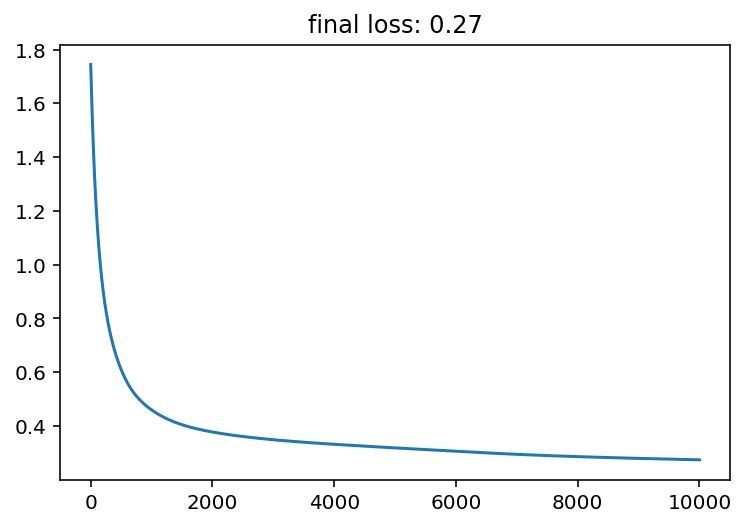

In [26]:
plt.plot(losses)
plt.title(f"final loss: {losses[-1]:.2f}")
plt.show()

We can use a confusion matrix to see how "confused" a model was. Read more on [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix).

In [27]:
from sklearn.metrics import confusion_matrix

y_pred = model(params, X.values)
confusion_matrix(y.values, np.round((y_pred)))

array([[647,  52],
       [ 62, 294]])

Text(33.0, 0.5, 'actual')

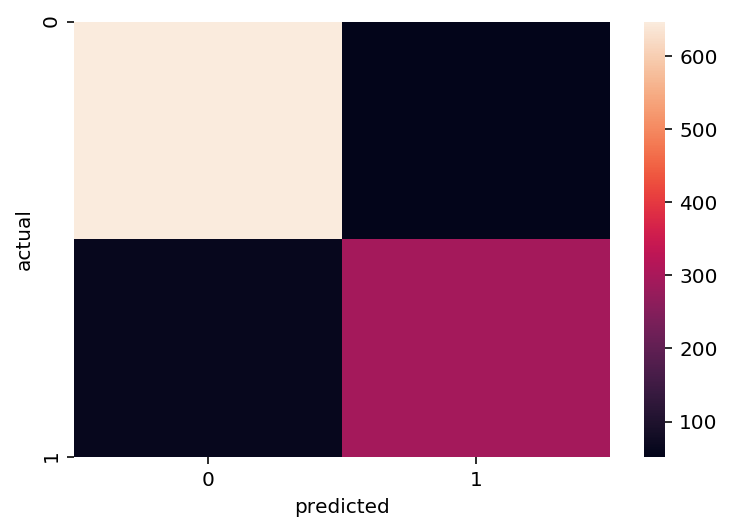

In [28]:
import seaborn as sns

sns.heatmap(confusion_matrix(y, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

# Recap

Deep learning, and more generally any modelling, has the following ingredients:

1. A model and its associated parameters to be optimized.
2. A loss function against which we are optimizing parameters.
3. An optimization routine.

You have seen these three ingredients at play with 3 different models: a linear regression model, a logistic regression model, and a deep feed forward neural network model.

## In Pictures

![](../figures/infographic.png) 

## Caveats of this tutorial

Deep learning is an active field of research. I have only shown you the basics here. In addition, I have also intentionally omitted certain aspects of machine learning practice, such as 

- splitting our data into training and testing sets, 
- performing model selection using cross-validation
- tuning hyperparameters, such as trying out optimizers
- regularizing the model, using L1/L2 regularization or dropout
- etc.

# Parting Thoughts

Deep learning is nothing more than optimization of a model with a really large number of parameters.

In its current state, it is not artificial intelligence. You should not be afraid of it; it is just a really powerful model that maps X to Y.

## Bonus: build a framework

In [29]:
# Let's build params
def consecutive_dense(shapes: list) -> dict:
    """
    Return a dictionary with 'w' and 'b' parameters
    of the correct shape
    
    The param dict p will have something like this as its
    structure:
    
    {
        'layer_0': {
            'w': (some random number),
            'b': (some random number)
        },
        'layer_1':{
            'w': (some random number),
            'b': (some random number)        
        }
    }
    
    usage:
        params = consecutive_dense([41, 20, 10, 1])
    
    :param shapes: Input -> Output column dimensions, as a
        sequential list of integers.
    :return p: a dictionary, with the appropriate nested 
        structure.
    """
    # Defensive programming checks.
    for i in shapes:
        if not isinstance(i, int):
            raise TypeError(f"Element {i} in shapes is not an integer")
    
    param_dict = dict()
    for i, (input_layer, output_layer) in enumerate(zip(shapes[:-1], shapes[1:])):
        param_dict[f"layer_{i}"] = dict()
        param_dict[f"layer_{i}"]['w'] = noise((input_layer, output_layer))
        param_dict[f"layer_{i}"]['b'] = noise((output_layer))
    
    return param_dict

In [30]:
params_test = consecutive_dense([41, 20, 1])

In [31]:
params_test['layer_0']['w'].shape

(41, 20)

In [32]:
params_test['layer_1']['b'].shape

(1,)

In [33]:
# Dense layer
def identity(x):
    """identity function"""
    return x

def dense(p, x, nonlin=identity):
    # activation
    a = np.dot(x, p['w']) + p['b']
    return nonlin(a)

In [34]:
# using consecutive_dense func.
params = consecutive_dense(shapes=[41, 20, 1])

# Redefine model func.
def model(p, x):
    a1 = dense(p['layer_0'], x, nonlin=np.tanh)
    a2 = dense(p['layer_1'], a1, nonlin=logistic)
    return a2

# SGD!
losses = []
for i in tqdmn(range(10000)):
    grad_p = dlogistic_loss(params, model, X.values, y.values)
    for layer, param in params.items():
        for k, v in param.items():
            param[k] = param[k] - grad_p[layer][k] * 0.01
    losses.append(logistic_loss(params, model, X.values, y.values))

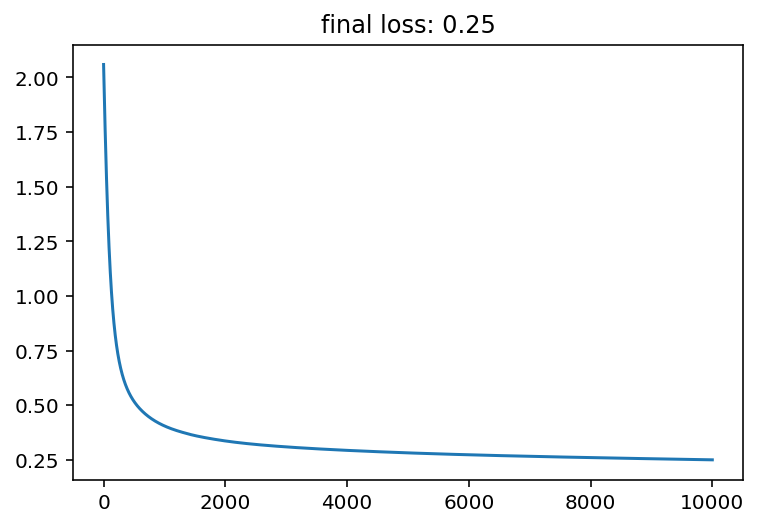

In [35]:
plt.plot(losses)
plt.title(f"final loss: {losses[-1]:.2f}")
plt.show()